In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile
import os

In [3]:
!mkdir -p Dataset/labels
!mkdir -p Dataset/images

In [4]:
classes = ['helmet', 'head', 'person', 'hat']

In [5]:
def convert_annot(size , box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

In [6]:
def save_txt_file(img_jpg_file_name, size, img_box):
    save_file_name = '/kaggle/working/Dataset/labels/' +  img_jpg_file_name + '.txt'
    
    with open(save_file_name ,'a+') as file_path:
        for box in img_box:

            cls_num = classes.index(box[0])

            new_box = convert_annot(size, box[1:])

            file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

        file_path.flush()
        file_path.close()

In [7]:
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    #print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
   
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
  
    save_txt_file(img_xml_file, [img_w, img_h], img_box)

In [8]:
!ls /kaggle/working/Dataset/labels

In [9]:
files = os.listdir('/kaggle/input/helmet-hat/archive/annotations')
for file in files:
#     print(file[:-4])
#     break
    file_xml = file[:-4]
    get_xml_data('/kaggle/input/helmet-hat/archive/annotations', file_xml)

In [10]:
from sklearn.model_selection import train_test_split
image_list = os.listdir('/kaggle/input/helmet-hat/archive/images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=42)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=42)
print('total =',len(image_list))
print('train :',len(train_list))
print('val   :',len(val_list))
print('test  :',len(test_list))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


total = 5287
train : 4229
val   : 529
test  : 529


In [11]:
def copy_data(file_list, img_labels_root, imgs_source, mode):

    root_file = Path( '/kaggle/working/Dataset/images/'+  mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    root_file = Path('/kaggle/working/Dataset/labels/' + mode)
    if not root_file.exists():
        print(f"Path {root_file} does not exit")
        os.makedirs(root_file)

    for file in file_list:               
        img_name = file.replace('.png', '')
        img_src_file = imgs_source + '/' + img_name + '.png'        
        label_src_file = img_labels_root + '/' + img_name + '.txt'

        # Copy image
        DICT_DIR = '/kaggle/working/Dataset/images/'  + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.png'

        copyfile(img_src_file, img_dict_file)

        # Copy label
        DICT_DIR = '/kaggle/working/Dataset/labels/' + mode
        img_dict_file = DICT_DIR + '/' + img_name + '.txt'
        copyfile(label_src_file, img_dict_file)

In [12]:
copy_data(train_list, '/kaggle/working/Dataset/labels', '/kaggle/input/helmet-hat/archive/images', "train")
copy_data(val_list,   '/kaggle/working/Dataset/labels', '/kaggle/input/helmet-hat/archive/images', "val")
copy_data(test_list,  '/kaggle/working/Dataset/labels', '/kaggle/input/helmet-hat/archive/images', "test")

Path /kaggle/working/Dataset/images/train does not exit
Path /kaggle/working/Dataset/labels/train does not exit
Path /kaggle/working/Dataset/images/val does not exit
Path /kaggle/working/Dataset/labels/val does not exit
Path /kaggle/working/Dataset/images/test does not exit
Path /kaggle/working/Dataset/labels/test does not exit


In [13]:
!ls /kaggle/working/Dataset/images

test  train  val


In [14]:
!git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 15151, done.
remote: Counting objects: 100% (1282/1282), done.
remote: Compressing objects: 100% (730/730), done.
remote: Total 15151 (delta 866), reused 816 (delta 552), pack-reused 13869
Receiving objects: 100% (15151/15151), 8.48 MiB | 18.63 MiB/s, done.
Resolving deltas: 100% (10342/10342), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.8/610.8 kB 10.9 MB/s eta 0:00:00a 0:00:01


In [15]:
import yaml

# Create configuration
config = {
   "path": "/kaggle/working/Dataset/images",
   "train": "train",
   "val": "val",
   "test": "test",
   "nc": 4,
   "names": ['helmet','head','person', 'hat'],
}
with open("data.yaml", "w") as file:
   yaml.dump(config, file, default_flow_style=False)

In [16]:
!cat data.yaml

names:
- helmet
- head
- person
- hat
nc: 4
path: /kaggle/working/Dataset/images
test: test
train: train
val: val


In [17]:
!wandb disabled

W&B disabled.


In [18]:
!yolo task=detect mode=train data=data.yaml model=yolov8s.pt epochs=80 lr0=0.001 batch=32 optimizer=Adam warmup_momentum=0.5 augment=True dropout=0.4 seed=1 flipud=0.7 device=0,1 hsv_h=0.7 hsv_s=0.7 hsv_v=0.7

100%|███████████████████████████████████████| 21.5M/21.5M [00:00<00:00, 155MB/s]
Ultralytics YOLOv8.0.163 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
                                                       CUDA:1 (Tesla T4, 15110MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=70, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=(0, 1), workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=1, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.4, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=Fals

In [20]:
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
import plotly.express as px
import pandas as pd

df = pd.read_csv("/kaggle/working/runs/detect/train/results.csv")
fig = px.line(df, x='                  epoch', y='       metrics/mAP50(B)', title='mAP50')
fig.show()

In [25]:
!yolo task=detect mode=val model=/kaggle/working/runs/detect/train/weights/best.pt data=data.yaml

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

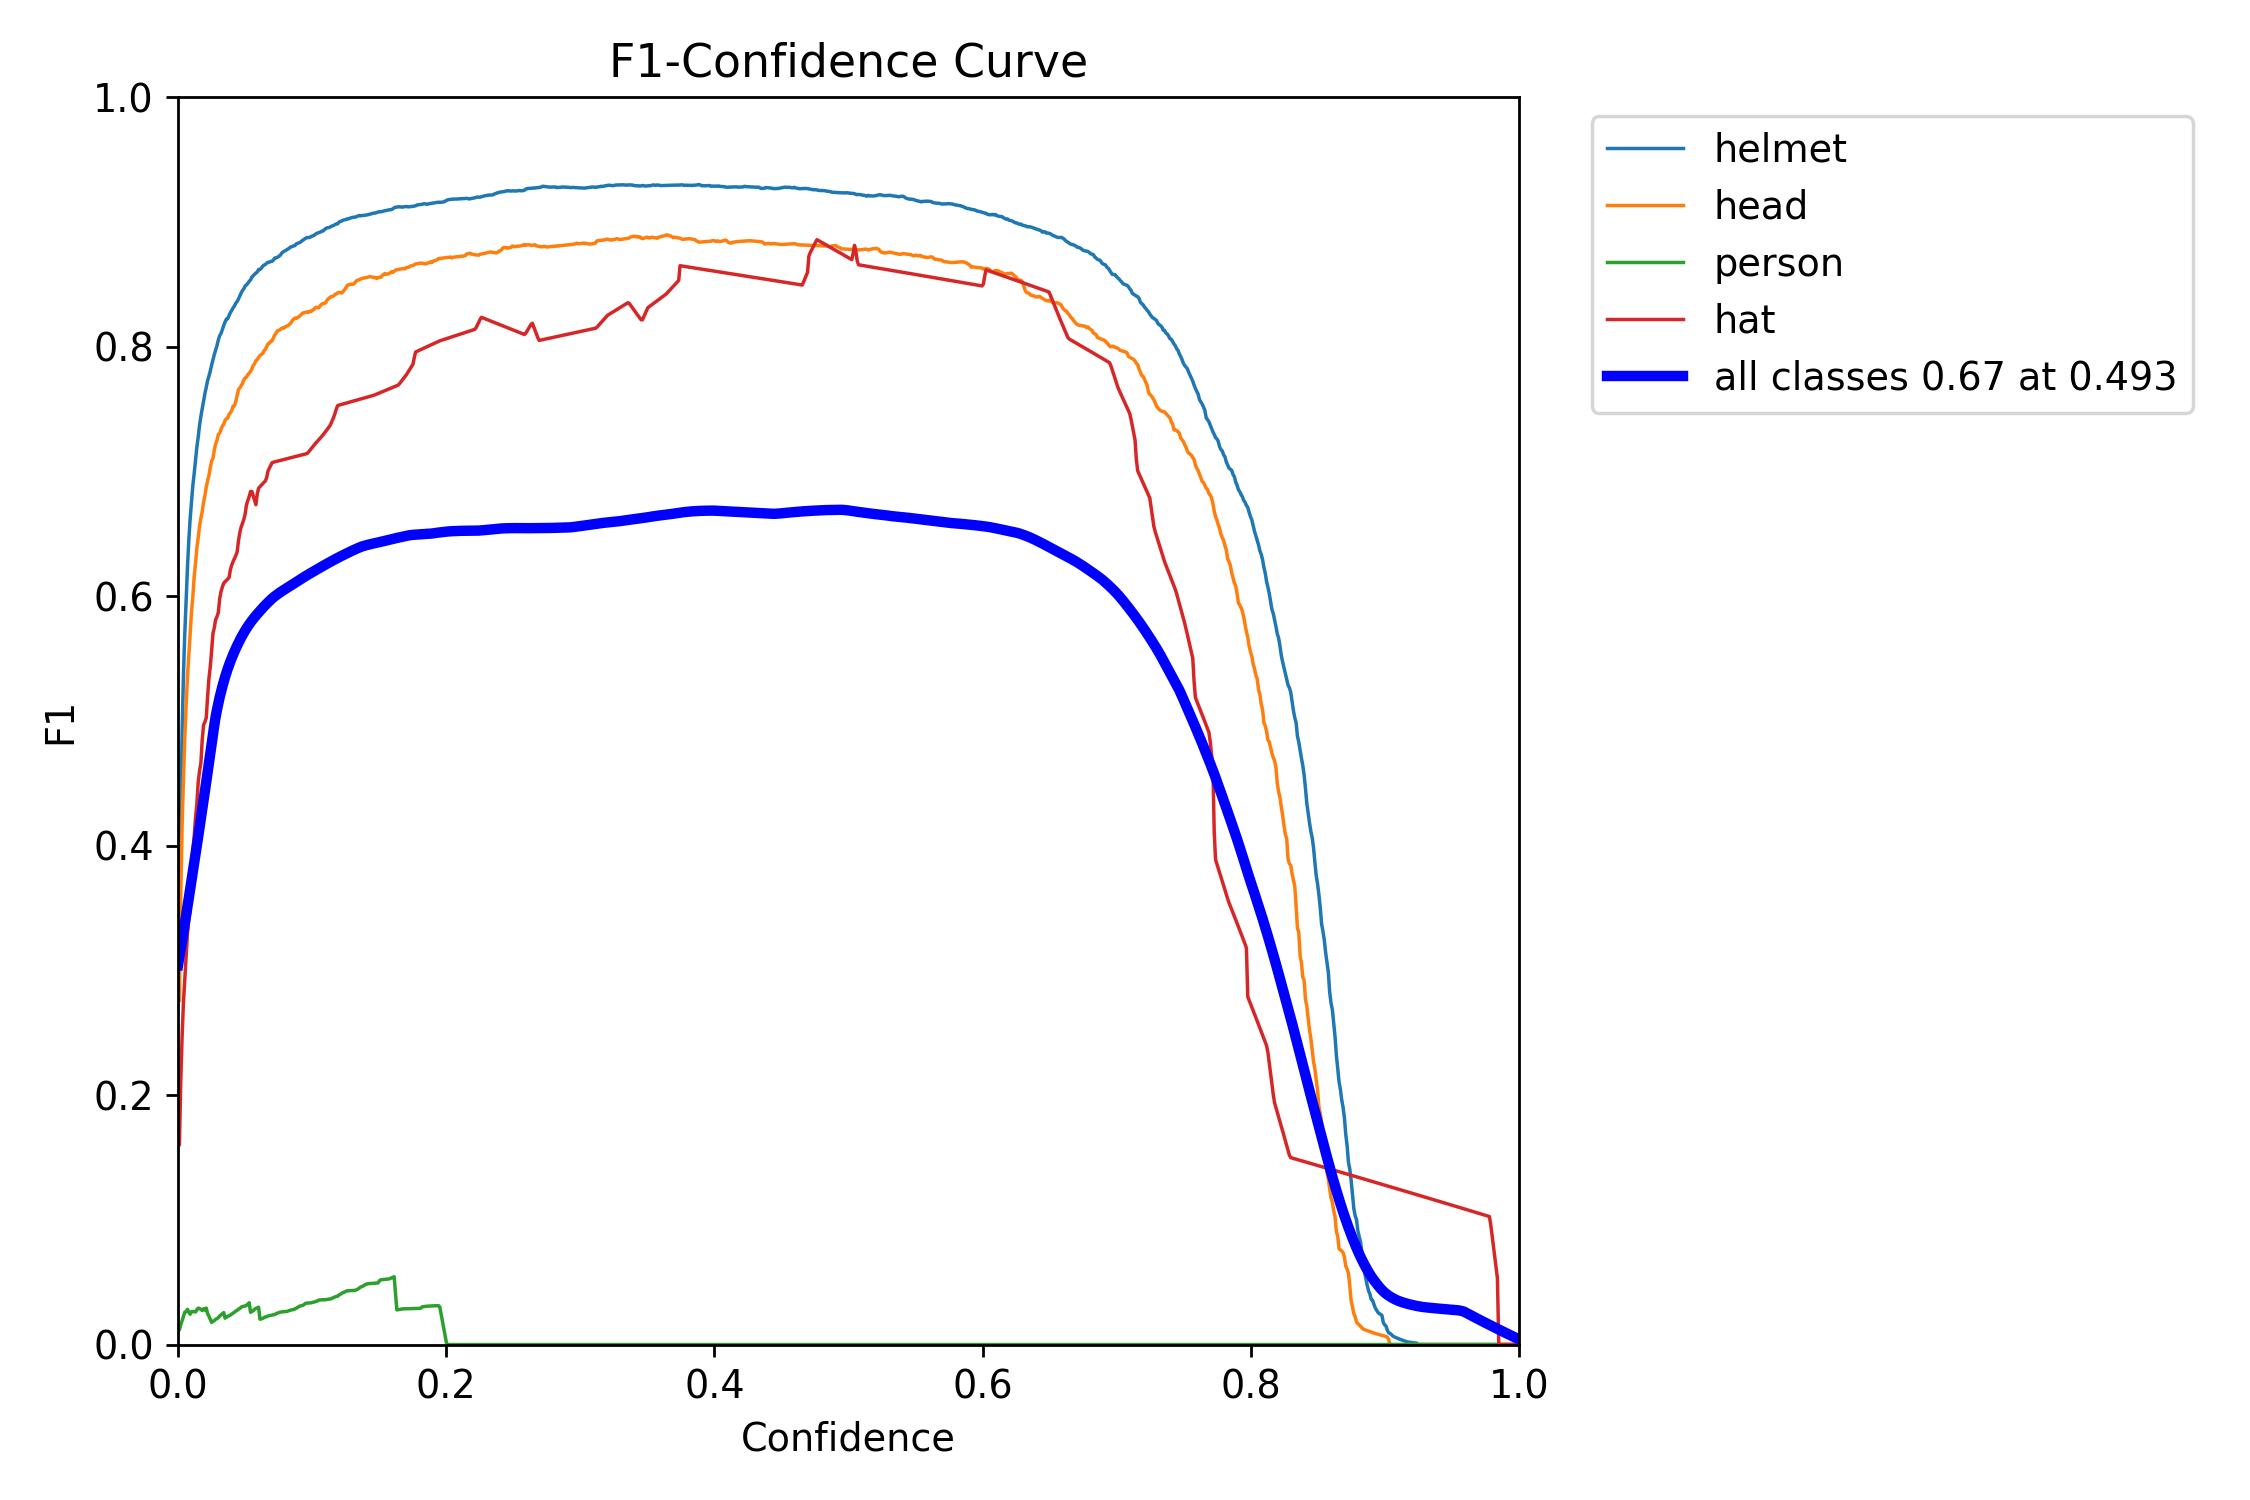

In [30]:
Image(filename='/kaggle/working/runs/detect/val/F1_curve.png', width=600)

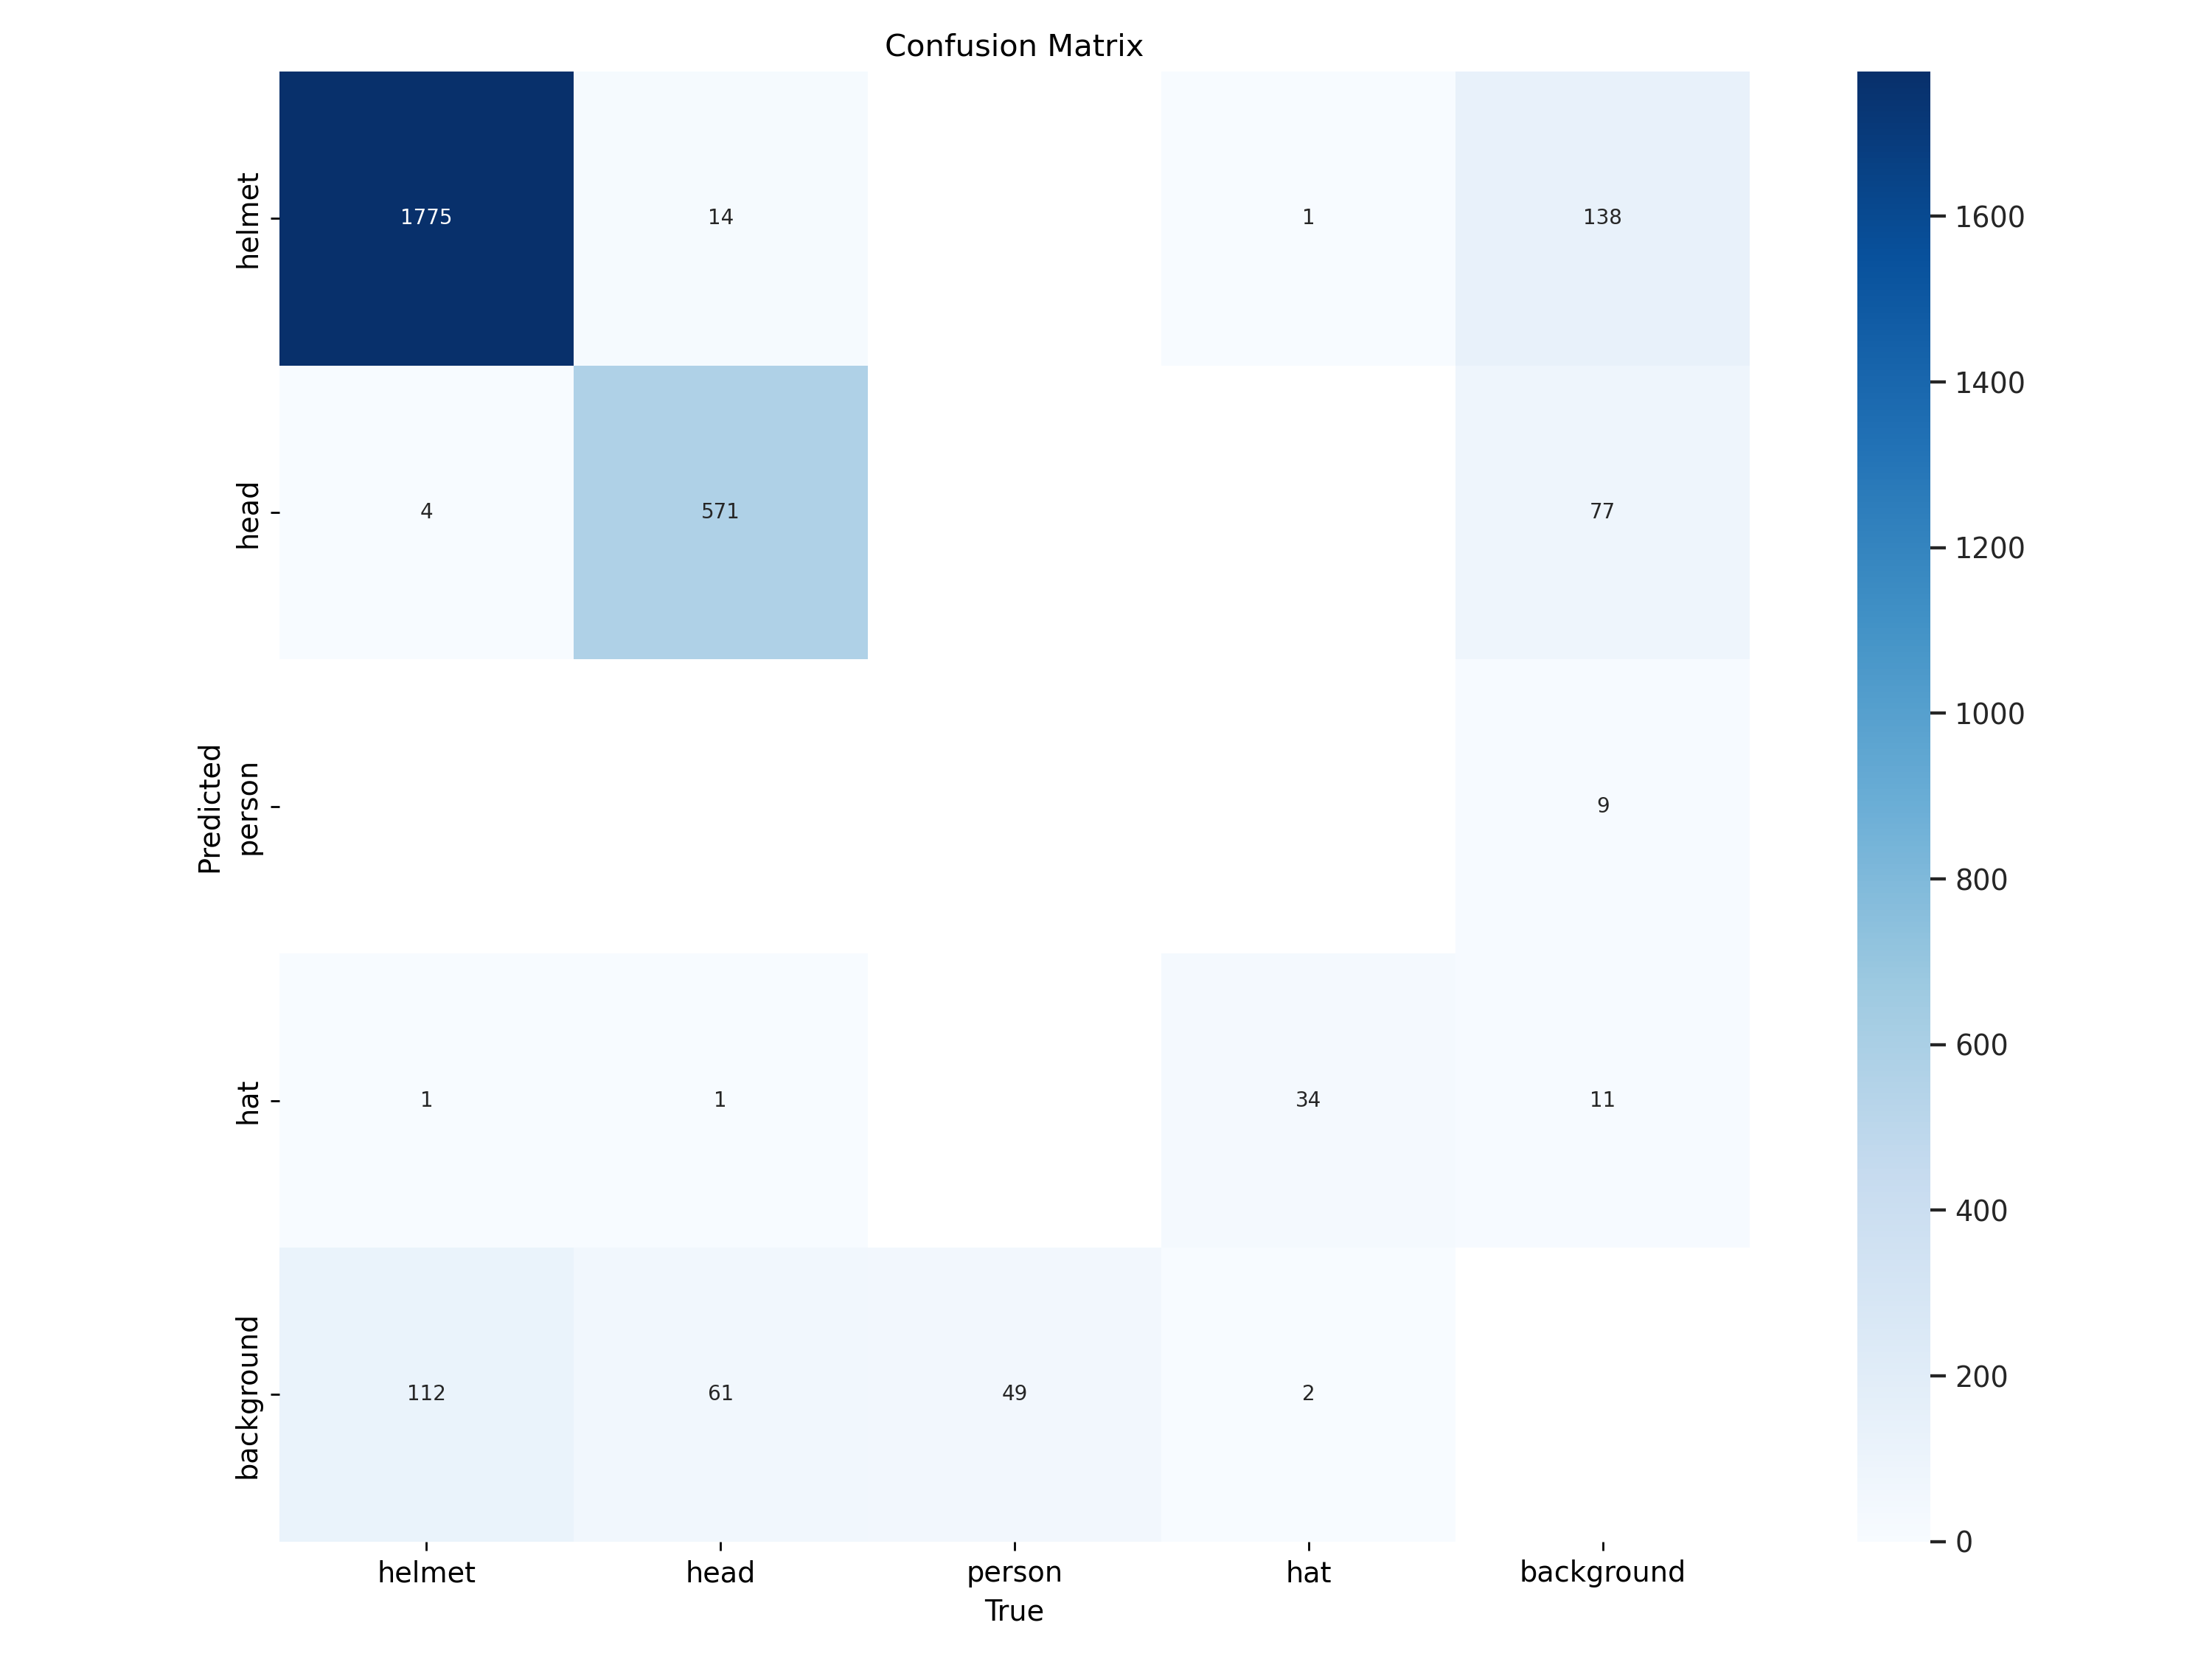

In [31]:
Image(filename='/kaggle/working/runs/detect/val/confusion_matrix.png', width=600)

In [34]:
!yolo predict model=/kaggle/working/runs/detect/train/weights/best.pt data=data.yaml source='/kaggle/input/test-image/Image20230825220220.jpg'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

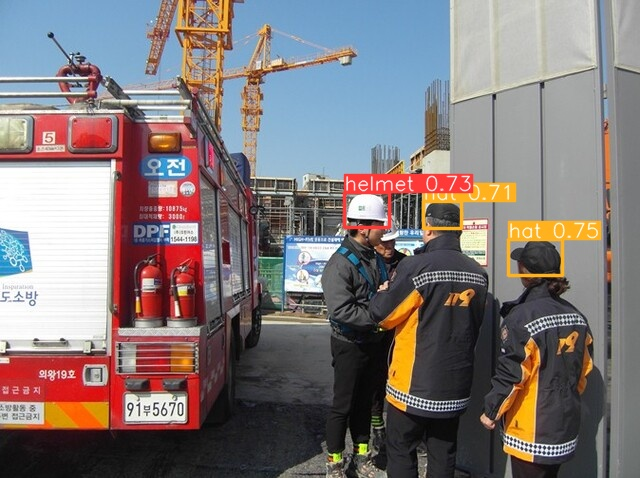

In [35]:
Image(filename='/kaggle/working/runs/detect/predict/Image20230825220220.jpg', width=600)